In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU

In [2]:
Autoencoder = tf.keras.models.load_model('k_fold_best_model_test1', compile=False)

In [3]:
phis=[0.93,1.0,1.10] 
Ts=[1160,1200,1130]

name_11='State_space_cte_pressure_T' 
name_12='_phi_'
name_21='Reaction_rates_cte_pressure_T'
name_22='_phi_'

end='.csv'

In [4]:
def hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:12]
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    n_columns_source=np.shape(cantera_sources)[1]
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[0,1:]
    maximum_values=maximum_values.to_numpy()
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [44]:
k=2
cantera_species=pd.read_csv(name_11+str(Ts[k])+name_12+str(phis[k])+end)
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(name_21+str(Ts[k])+name_22+str(phis[k])+end)
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
maximum_values=pd.DataFrame(maximum_values)

In [45]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)

In [46]:
results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()

In [47]:
interest_vector=['H2O','O2','H2','T[K]','OH','HO2','H2O2']

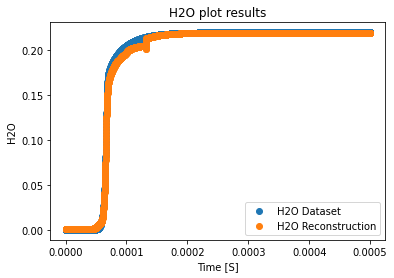

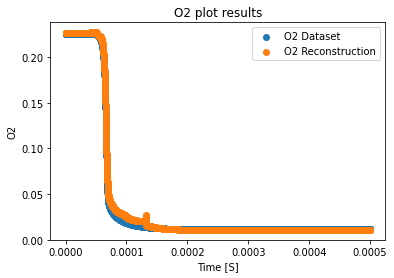

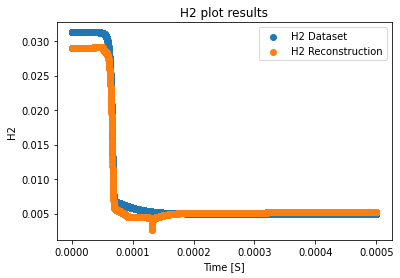

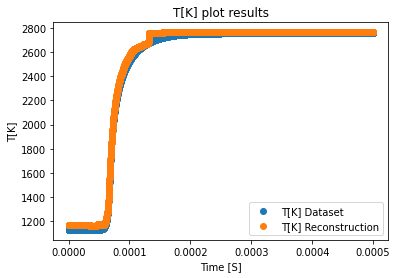

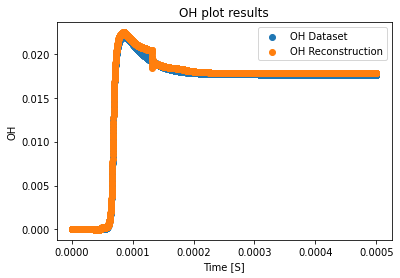

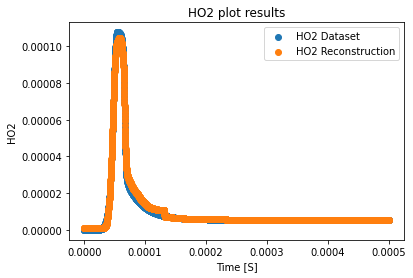

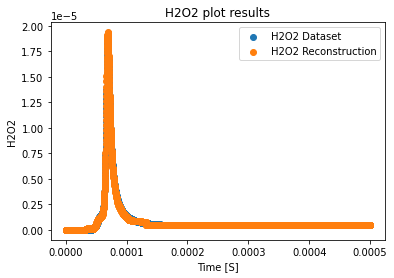

In [48]:
t_index=columns.index('t[s]shift')
t_trans=maximum_values.columns.get_loc('t[s]')
time_plot=(dataset.iloc[:,t_index])*maximum_values.iloc[0,t_trans]
    
for k in range(len(interest_vector)):
    original_index=columns.index(interest_vector[k]+'shift')
    #print(columns[original_index])
    results_index=columns.index(interest_vector[k]) #minues one due to the time column presence 
    #print(columns[results_index])
    #print(results_index-1)
    transformation_index=maximum_values.columns.get_loc(interest_vector[k])
    plot_name=interest_vector[k]+'.png'
    
    input_label=interest_vector[k]+' Dataset'
    output_label=interest_vector[k]+' Reconstruction'
    
    original=(dataset.iloc[:,original_index]).to_numpy()
    #original=original*transformation_values[1,original_index]
    #original=original+transformation_values[0,original_index]
    #original=np.exp(original)-1
    original=original*maximum_values.iloc[0,transformation_index]
    
    output=(results[:,results_index-1])
    #output=output*transformation_values[1,results_index]
    #output=output+transformation_values[0,results_index]
    #output=np.exp(output)-1
    output=output*maximum_values.iloc[0,transformation_index]
    
    plt.figure(k)
    plt.scatter(time_plot,original, label=input_label)
    plt.scatter(time_plot,output, label=output_label)
    plt.title(interest_vector[k]+' plot results')
    plt.xlabel('Time [S]')
    plt.ylabel(interest_vector[k])
    plt.legend()

In [49]:
latent_space=Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy())).numpy()

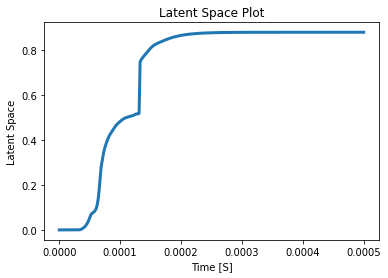

In [50]:
reduced_size=1

if reduced_size==1:
    plt.figure()
    plt.plot(time_plot,latent_space,linewidth=3)
    plt.title('Latent Space Plot')
    plt.xlabel('Time [S]')
    plt.ylabel('Latent Space')
else: 
    for i in range(reduced_size):
            plt.figure(i)
            plt.plot(time_plot,latent_space[:,i],linewidth=3)
            plt.title('Latent Space Plot')
            plt.xlabel('Time [S]')
            plt.ylabel('Latent Space')

In [51]:
corr_dataset=dataset.iloc[:,1:2+n_columns_mass_fraction+n_columns_source]
corr_columns=corr_dataset.columns.to_list()
corr_dataset

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,0.405757,0.971234,3.026851e-10,0.994361,9.347321e-12,1.329399e-11,2.724084e-13,4.589856e-07,5.596190e-11,-7.574802e-09,1.633590e-08,-1.719316e-08,1.413516e-09,1.396800e-09,6.092578e-11,3.636539e-05,5.486612e-09
1,0.405757,0.971234,6.014564e-10,0.994361,3.189426e-11,5.045361e-11,1.892945e-12,9.209433e-07,2.241949e-10,-7.713904e-09,1.621257e-08,-1.762723e-08,2.236168e-09,2.582811e-09,2.078866e-10,3.659881e-05,1.100727e-08
2,0.405757,0.971234,8.991601e-10,0.994361,6.241024e-11,1.079589e-10,5.724130e-12,1.385850e-06,5.054338e-10,-7.907737e-09,1.621198e-08,-1.805974e-08,2.768613e-09,3.600392e-09,4.067895e-10,3.683138e-05,1.656168e-08
3,0.405757,0.971234,1.197712e-09,0.994361,9.834179e-11,1.830035e-10,1.230312e-11,1.853703e-06,9.003646e-10,-8.141693e-09,1.629900e-08,-1.849348e-08,3.150110e-09,4.481558e-09,6.409912e-10,3.706461e-05,2.214983e-08
4,0.405757,0.971234,1.498501e-09,0.994361,1.383374e-10,2.733067e-10,2.201249e-11,2.324521e-06,1.409677e-09,-8.407410e-09,1.645312e-08,-1.893047e-08,3.448796e-09,5.251492e-09,9.016825e-10,3.729958e-05,2.777189e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.989192,0.153838,1.399595e-01,0.050045,7.513178e-01,1.601142e-01,9.858607e-01,4.845972e-02,2.044816e-02,-4.553975e-09,-1.103661e-08,-4.791530e-09,-3.345335e-08,-1.431179e-08,1.125345e-08,-7.830790e-09,-2.416850e-09
4995,0.989192,0.153838,1.399595e-01,0.050045,7.513178e-01,1.601142e-01,9.858607e-01,4.845972e-02,2.044816e-02,-4.538464e-09,-1.099903e-08,-4.775213e-09,-3.333937e-08,-1.426306e-08,1.121513e-08,-7.804183e-09,-2.408601e-09
4996,0.989192,0.153838,1.399595e-01,0.050045,7.513178e-01,1.601142e-01,9.858607e-01,4.845972e-02,2.044816e-02,-4.523011e-09,-1.096157e-08,-4.758951e-09,-3.322563e-08,-1.421458e-08,1.117692e-08,-7.777544e-09,-2.400436e-09
4997,0.989192,0.153838,1.399595e-01,0.050045,7.513178e-01,1.601142e-01,9.858607e-01,4.845972e-02,2.044816e-02,-4.507609e-09,-1.092424e-08,-4.742745e-09,-3.311294e-08,-1.416599e-08,1.113889e-08,-7.751061e-09,-2.392228e-09


In [52]:
iterations=np.shape(corr_dataset)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes=np.zeros(iterations) #rows, columns
    corr_indexes=np.array([corr_indexes])
    
    for j in range(iterations):
        corr_indexes[:,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space)
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)
else: 
    
    corr_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes[k,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space[:,k])
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)

In [53]:
corr_indexes

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,0.999112,-0.999485,-0.53495,-0.999567,-0.467733,-0.520698,0.999567,-0.707147,-0.610603,0.778901,0.526609,0.793599,0.425589,0.520038,-0.766776,0.602618,0.522911


H2O      0.999567
T[K]     0.999112
O2w      0.793599
H2w      0.778901
HO2w     0.602618
Hw       0.526609
H2O2w    0.522911
Ow       0.520038
OHw      0.425589
OH      -0.467733
O       -0.520698
H       -0.534950
H2O2    -0.610603
HO2     -0.707147
H2Ow    -0.766776
H2      -0.999485
O2      -0.999567
Name: 0, dtype: float64


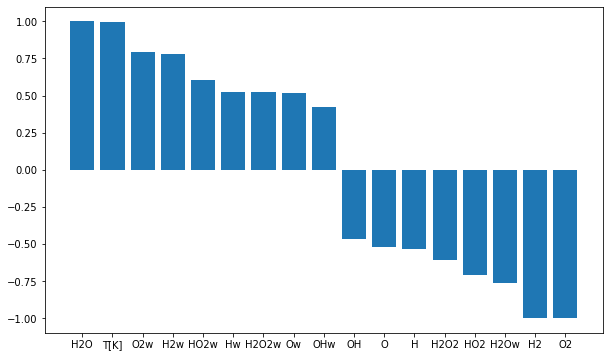

In [54]:
for m in range(reduced_size):
    
    indexes=corr_indexes.iloc[m,:].sort_values(ascending=False)
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [55]:
if reduced_size==1:
    spearman_indexes=np.zeros(iterations) #rows, columns
    spearman_indexes=np.array([spearman_indexes])
    
    for j in range(iterations):
        spearman_indexes[:,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space)
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)
else: 
    
    spearman_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            spearman_indexes[k,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space[:,k])
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)

In [56]:
spearman_indexes

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,0.999987,-0.999995,-0.349142,-0.999996,-0.264832,-0.329987,0.999996,-0.589953,-0.460431,0.78799,0.291353,0.810089,0.156314,0.281766,-0.764607,0.41032,0.286978


H2O      0.999996
T[K]     0.999987
O2w      0.810089
H2w      0.787990
HO2w     0.410320
Hw       0.291353
H2O2w    0.286978
Ow       0.281766
OHw      0.156314
OH      -0.264832
O       -0.329987
H       -0.349142
H2O2    -0.460431
HO2     -0.589953
H2Ow    -0.764607
H2      -0.999995
O2      -0.999996
Name: 0, dtype: float64


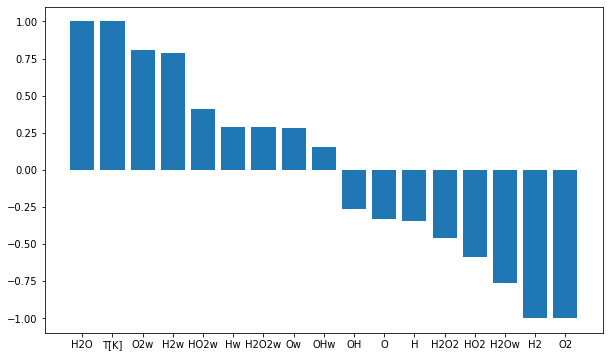

In [57]:
for m in range(reduced_size):
    
    indexes=spearman_indexes.iloc[m,:].sort_values(ascending=False)
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [58]:
n_samples=np.shape(latent_space)[0]

corr_dataset_=corr_dataset.iloc[1:,:]

latent_space_=latent_space[0:n_samples-1,:]

In [59]:
print(np.shape(corr_dataset_))
print(np.shape(latent_space_))

(4998, 17)
(4998, 1)


In [60]:
iterations=np.shape(corr_dataset_)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes_=np.zeros(iterations) #rows, columns
    corr_indexes_=np.array([corr_indexes_])
    
    for j in range(iterations):
        corr_indexes_[:,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_)
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)
else: 
    
    corr_indexes_=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes_[k,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_[:,k])
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)

In [61]:
corr_indexes_

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,0.999127,-0.999485,-0.535564,-0.999566,-0.468321,-0.521307,0.999566,-0.70783,-0.611248,0.779586,0.527112,0.794256,0.426025,0.520536,-0.767484,0.603172,0.52341


H2O      0.999566
T[K]     0.999127
O2w      0.794256
H2w      0.779586
HO2w     0.603172
Hw       0.527112
H2O2w    0.523410
Ow       0.520536
OHw      0.426025
OH      -0.468321
O       -0.521307
H       -0.535564
H2O2    -0.611248
HO2     -0.707830
H2Ow    -0.767484
H2      -0.999485
O2      -0.999566
Name: 0, dtype: float64


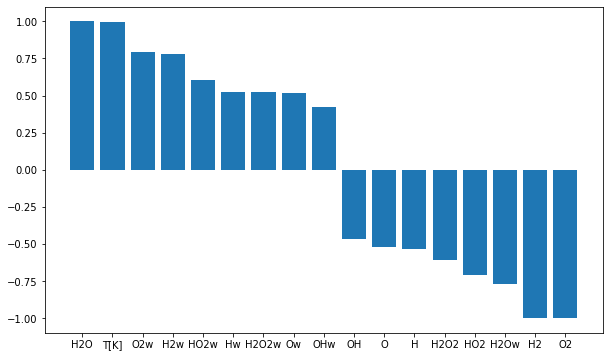

In [62]:
for m in range(reduced_size):
    
    indexes=corr_indexes_.iloc[m,:].sort_values(ascending=False)
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)